In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import sys
sys.path.append('../')

from utils.processing import *
from utils.visualisation import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, validation_curve
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import DBSCAN

np.random.seed(0)

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 80)

In [4]:
# load data set
df = pd.read_csv('../data/train.csv')
df_train_orig = df.copy()

In [5]:
# Utility functions
def prepare_data_for_regression(df, drop_columns=[]):
    adfs = read_aux_csv('../data')
    df = join_aux(df, adfs)
    df = df.drop(columns=drop_columns)

    return df

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    score = np.sqrt(mse)
    return score

def rmse_scorer():
    return make_scorer(rmse, greater_is_better=False)

def split_data(df):
    X = df.drop('price', axis=1)
    y = df['price']
    
    return X, y

# Constants
initial_drop_columns = [
    'address',
    'title',
    'listing_id',
    'property_name',
    'available_unit_types',
    'property_details_url',
    'elevation',
    'tenure',
    'property_type',
    'floor_level',
    'furnishing',
]

drop_columns = initial_drop_columns + [
    'area_size',
    'population',
    'subzone',
    'lat',
    'lng',
    
    'tenure_low_year',
    'floor_level_ground',
    'floor_level_high',
    'floor_level_low',
    'floor_level_mid',
    'floor_level_penthouse',
    'floor_level_top',
    'furnishing_partial',
    'furnishing_unfurnished',
    'furnishing_unspecified',
    'line_cc',
    'line_ce',
    'line_cg',
    'line_dt',
    'line_ew',
    'line_ne',
    'line_ns',
    'line_te',
    'gep_pri_sch_within_1km',
    'gep_pri_sch_within_1km_2km',
    'gep_pri_sch_outside_2km',
    'pri_sch_within_500m',
    'pri_sch_outside_500m',
    'cc_type_BN',
    'cc_type_CR',
    'cc_type_IEBP',
    'cc_type_IHL'
]

In [6]:
# Prepare training data set
df_train = preprocess(df_train_orig.copy())
df_train = prepare_data_for_regression(df_train, drop_columns=drop_columns)
df_train

,built_year,num_beds,num_baths,size_sqft,total_num_units,planning_area,price,property_type_private,property_type_public,tenure_high_year,nearest_mrt_distance_in_km,nearest_pri_sch_distance_in_km,nearest_gep_pri_sch_distance_in_km,nearest_com_centre_distance_in_km,nearest_mall_distance_in_km,density,region
0,1988.0,3.0,2.0,1115.0,116.0,yishun,514500.0,0,1,0,0.574204,0.275582,6.194099,3.338999,0.621334,31517.683928,n
1,1992.0,4.0,2.0,1575.0,NaN,serangoon,995400.0,0,1,0,1.734303,0.122925,0.122925,2.401882,0.552544,23280.268731,ne
2,2022.0,4.0,6.0,3070.0,56.0,marine parade,8485000.0,1,0,1,1.319766,0.891475,1.872702,2.171328,0.824208,5829.779777,c
3,2023.0,3.0,2.0,958.0,638.0,bukit timah,2626000.0,1,0,1,0.726006,1.090371,1.090371,1.605928,0.907063,11059.413028,c
4,2026.0,2.0,1.0,732.0,351.0,downtown core,1764000.0,1,0,0,0.371115,0.464835,2.742534,1.869574,0.430415,775.193798,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20140,2026.0,2.0,2.0,635.0,605.0,ang mo kio,1050000.0,1,0,0,0.149941,0.790370,4.691173,3.163579,2.014133,2384.380061,ne
20141,2026.0,2.0,2.0,883.0,137.0,kallang,2087400.0,1,0,1,0.443603,0.660929,2.178475,1.641446,0.535185,12802.219580,c
20142,2023.0,4.0,4.0,1378.0,340.0,novena,4193700.0,1,0,1,0.424244,0.367552,0.367552,0.856170,0.764410,6901.669759,c
20143,2017.0,3.0,2.0,1205.0,402.0,woodlands,754800.0,0,1,0,0.631718,0.230075,10.658711,2.165768,0.601720,38762.482867,n


In [7]:
X_train, y_train = split_data(df_train)

In [8]:
ct = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ["region", "planning_area"]),
    remainder='passthrough')

def ttr(pipeline):
    return TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

def transform_data(df):
    p = make_pipeline(ct, StandardScaler(), KNNImputer())
    p.fit(df)
    
    return pd.DataFrame(data=p.transform(df), columns=p.get_feature_names_out())

In [9]:
t_X_train = transform_data(X_train)
t_X_train[t_X_train.isna().any(axis=1)]

,onehotencoder__region_c,onehotencoder__region_e,onehotencoder__region_n,onehotencoder__region_ne,onehotencoder__region_w,onehotencoder__planning_area_ang mo kio,onehotencoder__planning_area_bedok,onehotencoder__planning_area_bishan,onehotencoder__planning_area_bukit batok,onehotencoder__planning_area_bukit merah,onehotencoder__planning_area_bukit panjang,onehotencoder__planning_area_bukit timah,onehotencoder__planning_area_central water catchment,onehotencoder__planning_area_changi,onehotencoder__planning_area_choa chu kang,onehotencoder__planning_area_clementi,onehotencoder__planning_area_downtown core,onehotencoder__planning_area_geylang,onehotencoder__planning_area_hougang,onehotencoder__planning_area_jurong east,onehotencoder__planning_area_jurong west,onehotencoder__planning_area_kallang,onehotencoder__planning_area_lim chu kang,onehotencoder__planning_area_mandai,onehotencoder__planning_area_marine parade,...,onehotencoder__planning_area_sembawang,onehotencoder__planning_area_sengkang,onehotencoder__planning_area_serangoon,onehotencoder__planning_area_singapore river,onehotencoder__planning_area_southern islands,onehotencoder__planning_area_tampines,onehotencoder__planning_area_tanglin,onehotencoder__planning_area_tengah,onehotencoder__planning_area_toa payoh,onehotencoder__planning_area_woodlands,onehotencoder__planning_area_yishun,remainder__built_year,remainder__num_beds,remainder__num_baths,remainder__size_sqft,remainder__total_num_units,remainder__property_type_private,remainder__property_type_public,remainder__tenure_high_year,remainder__nearest_mrt_distance_in_km,remainder__nearest_pri_sch_distance_in_km,remainder__nearest_gep_pri_sch_distance_in_km,remainder__nearest_com_centre_distance_in_km,remainder__nearest_mall_distance_in_km,remainder__density


In [10]:
def plot_validation(regr, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(regr, X, y, param_name=param_name, scoring=rmse_scorer(), param_range=param_range)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if param_range[0] == None:
        param_range[0] = 0
    
    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    lw = 2

    plt.plot(
        param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.plot(
        param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show()

In [11]:
regr = ttr(make_pipeline(ct, StandardScaler(), KNNImputer(), xgb.XGBRegressor(n_jobs=-2)))
regr_pca = ttr(make_pipeline(ct, StandardScaler(), KNNImputer(), PCA(), xgb.XGBRegressor(n_jobs=-2)))

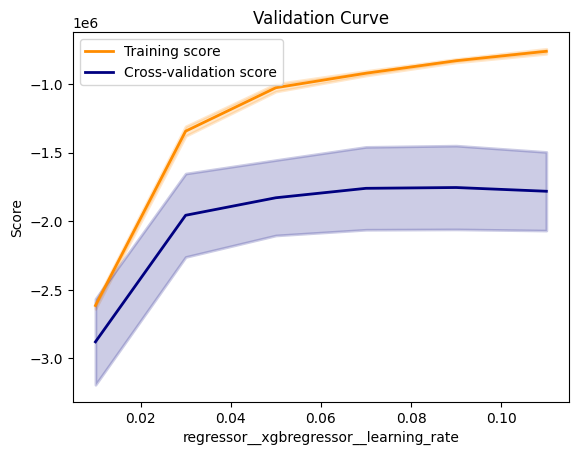

CPU times: user 15min 53s, sys: 6min 38s, total: 22min 32s
Wall time: 4min 31s


In [12]:
%%time
plot_validation(regr, X_train, y_train, 'regressor__xgbregressor__learning_rate', [0.01, 0.03, 0.05, 0.07, 0.09, 0.11])

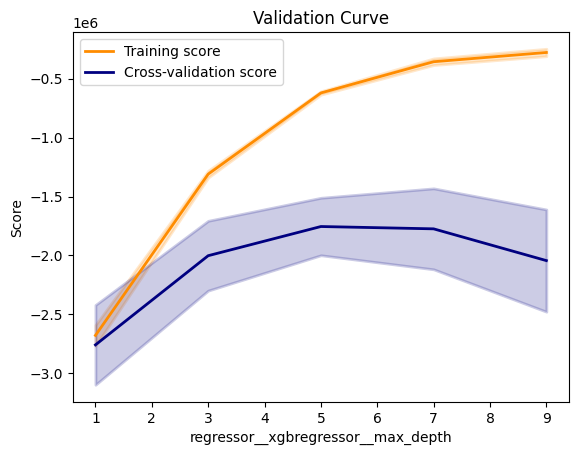

CPU times: user 12min 46s, sys: 5min 32s, total: 18min 18s
Wall time: 3min 44s


In [13]:
%%time
plot_validation(regr, X_train, y_train, 'regressor__xgbregressor__max_depth', [1, 3, 5, 7, 9])

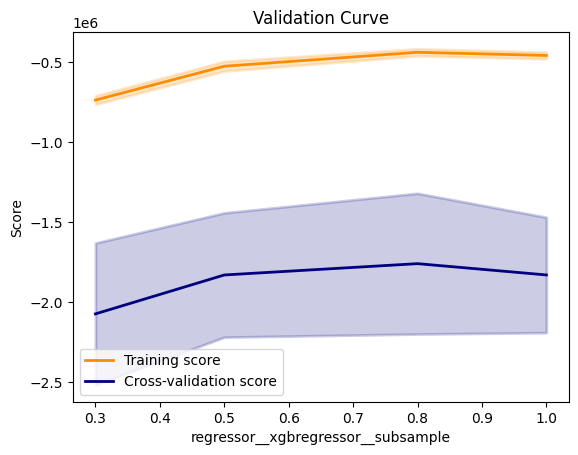

CPU times: user 10min 30s, sys: 4min 25s, total: 14min 56s
Wall time: 3min


In [14]:
%%time
plot_validation(regr, X_train, y_train, 'regressor__xgbregressor__subsample', [0.3, 0.5, 0.8, 1.0])

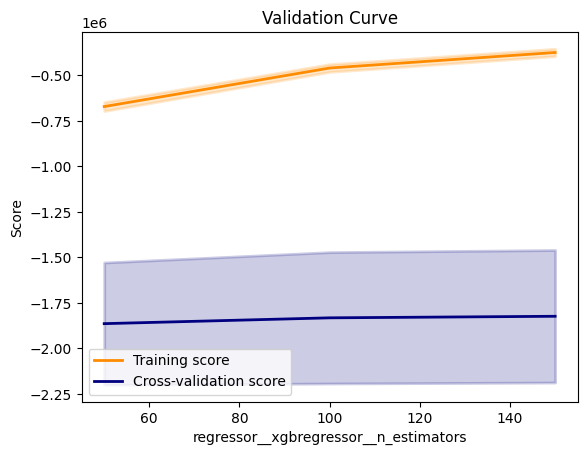

In [15]:
plot_validation(regr, X_train, y_train, 'regressor__xgbregressor__n_estimators', [50, 100, 150])

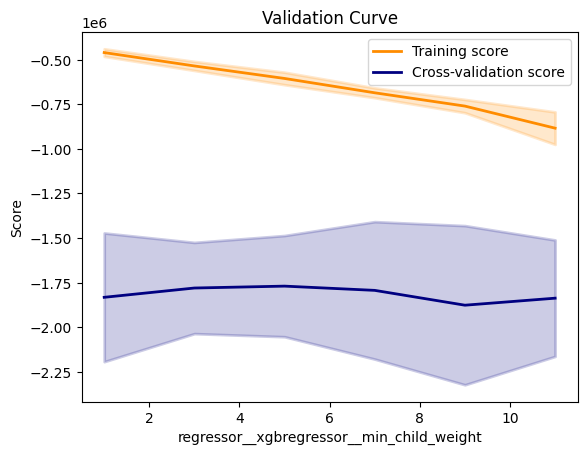

CPU times: user 15min 41s, sys: 6min 38s, total: 22min 20s
Wall time: 4min 35s


In [16]:
%%time
plot_validation(regr, X_train, y_train, 'regressor__xgbregressor__min_child_weight', [1, 3, 5, 7, 9, 11])

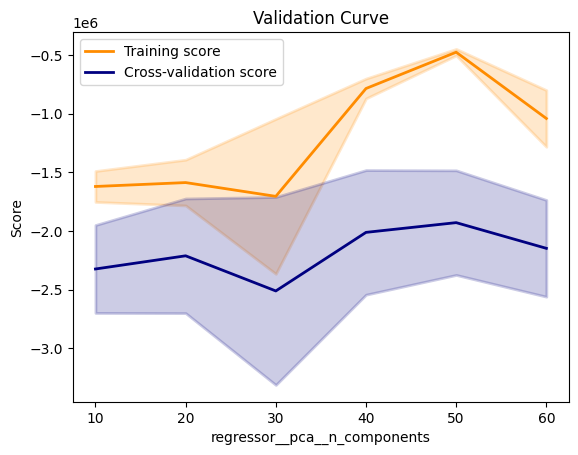

CPU times: user 19min 16s, sys: 8min 24s, total: 27min 40s
Wall time: 4min 48s


In [17]:
%%time
plot_validation(regr_pca, X_train, y_train, 'regressor__pca__n_components', [10, 20, 30, 40, 50, 60])

In [18]:
def run_search_models(pipeline, params, X, y):    
    search = GridSearchCV(ttr(pipeline), params, cv=5, scoring=rmse_scorer())
    search.fit(X, y)
    
    return search

In [19]:
%%time
def run_search_xgboost():
    pipeline = make_pipeline(ct, StandardScaler(), KNNImputer(), xgb.XGBRegressor(n_jobs=-2))

    params = {
        'regressor__xgbregressor__max_depth': [5, 6, 7],                                                                                                                  
        'regressor__xgbregressor__learning_rate': [0.03, 0.05, 0.08],
    }
                                                
    return run_search_models(pipeline, params, X_train, y_train)            

search_xgboost = run_search_xgboost()

CPU times: user 16min 36s, sys: 6min 19s, total: 22min 55s
Wall time: 4min 2s


In [20]:
print("%d %s" % (search_xgboost.best_score_, search_xgboost.best_params_))

-1756312 {'regressor__xgbregressor__learning_rate': 0.08, 'regressor__xgbregressor__max_depth': 6}


In [21]:
%%time

def run_search_pca():
    pipeline = make_pipeline(ct, StandardScaler(), KNNImputer(), PCA(), xgb.XGBRegressor(n_jobs=-2))

    params = {
        'regressor__pca__n_components': [40, 50, 60],
        'regressor__xgbregressor__max_depth': [5, 6, 7],
        'regressor__xgbregressor__learning_rate': [0.03, 0.05, 0.08],
    }

    return run_search_models(pipeline, params, X_train, y_train)

search_pca = run_search_pca()

CPU times: user 1h 12min 8s, sys: 23min 57s, total: 1h 36min 6s
Wall time: 13min 17s


In [22]:
print("%d %s" % (search_pca.best_score_, search_pca.best_params_))

-1912745 {'regressor__pca__n_components': 50, 'regressor__xgbregressor__learning_rate': 0.08, 'regressor__xgbregressor__max_depth': 7}
